### Importing all the used libraries in the project

In [128]:
import numpy as np
import torch
import math
import torch.nn as nn
from scipy.integrate import quad
import matplotlib.pyplot as plt

import copy

Define user-defined target function
$$
V(t) = u(t - a) - u(t - b)
$$

In [129]:
def u(x, threshold):
    return (x >= threshold).float()

In [130]:
def user_defined_function(x):
    if isinstance(x, float) or isinstance(x, np.ndarray):  # Convert float or NumPy array to tensor
        x = torch.tensor(x, dtype=torch.float32)
    
    pulse_width = 2.0  # Width of each pulse
    period = 5.0       # Period of oscillation
    offset = 0.5       # To center the pulse around the y-axis
    
    pulses = torch.zeros_like(x)
    for i in range(int((x.max() + 1) // period) + 1):
        start = i * period
        pulses += u(x, start + offset) - u(x, start + pulse_width + offset)
    
    return pulses if pulses.numel() > 1 else pulses.item()

Define R(x) function
$$
R_M(x) = a + b.x
$$

In [131]:
a, b = np.random.randint(1, 11, size=2)  # Random values for a and b
def R(x):
    return a + b * x

Define dx/dt function

In [132]:
def dxdt(x, t, V):
    k = 1  # Proportionality constant
    V_on = 0  # Threshold voltage
    return k * (V - V_on)

In [133]:
# Get x over time
def get_x_over_time(V_func, t_vals, x0):
    x_vals = np.zeros_like(t_vals)
    for i, t in enumerate(t_vals):
        if i == 0:
            x_vals[i] = x0
        else:
            dt = t_vals[i] - t_vals[i-1]
            V_current = V_func(t_vals[i-1])  
            x_vals[i] = x_vals[i-1] + dxdt(x_vals[i-1], t, V_current) * dt  
    return x_vals

The equation for \( Q \) can be expressed as:

$$
Q = \int_{t_i}^{t_f} \frac{V^2(t)}{R_M(x)} \, dt
$$

In [134]:
def compute_Q(V_func, x0, t_i, t_f):
    def integrand(t):
        x = get_x_over_time(V_func, [t], x0)[0]  
        V_t = V_func(t)  
        R_x = R(x)                  
        return (V_t ** 2) / R_x     

    Q, _ = quad(integrand, t_i, t_f)
    return Q

Neural Network Model

In [136]:
class VoltagePredictor(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(VoltagePredictor, self).__init__()
        
        # Create a list to hold the layers
        layers = []
        prev_size = input_size
        
        # Create hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, output_size))
        
        # Combine all layers into a Sequential module
        self.model = nn.Sequential(*layers)
        
        self.init_weights()

    def init_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                # Random weight and bias = .normal_ / Constant weight and bias = _constant
                nn.init.normal_(layer.weight, mean=0, std=1)
                nn.init.normal_(layer.bias, mean=0, std=1)
    
    def forward(self, x):
        for layer in self.model[:-1]:  # Exclude the last layer for now
            x = torch.tanh(layer(x))  # Use arctan activation function
        x = self.model[-1](x)  # Output layer
        return x

    def get_output(self, time):
        """Get neural network output for a given time input."""
        time_tensor = torch.tensor([[time]], dtype=torch.float32)
        with torch.no_grad():
            return self(time_tensor).item()


Initialize population models

In [137]:
input_size = 1
hidden_sizes = [20, 20, 20, 20, 20]
output_size = 1
n_pop = 20
pop = [VoltagePredictor(input_size, hidden_sizes, output_size) for _ in range(n_pop)]


Compute Q for target function

In [138]:
t_vals = np.linspace(0, 10, 500)
x0 = 0
Q_target = compute_Q(user_defined_function, x0, t_vals[0], t_vals[-1])

In [139]:
Q_values = []
model_outputs = []
for i, model in enumerate(pop):
    Q_value = compute_Q(model.get_output, x0, t_vals[0], t_vals[-1])
    Q_values.append((i + 1, Q_value))
    model_outputs.append([model.get_output(t) for t in t_vals])

/var/folders/29/b0gj9jmd6p7_zckwsxfjxty80000gs/T/ipykernel_11007/647666068.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Q, _ = quad(integrand, t_i, t_f)
/var/folders/29/b0gj9jmd6p7_zckwsxfjxty80000gs/T/ipykernel_11007/647666068.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Q, _ = quad(integrand, t_i, t_f)


Printing the Q resault for each population and also for the target function

In [140]:
print(f"Target V(t): Q = {Q_target:.4f}")
for num, Q in Q_values:
    print(f"Model {num}: Q = {Q:.4f}")

Target V(t): Q = 0.5000
Model 1: Q = 4.7855
Model 2: Q = 1.8919
Model 3: Q = 16.0836
Model 4: Q = 21.9102
Model 5: Q = 56.6743
Model 6: Q = 37.2481
Model 7: Q = 24.6961
Model 8: Q = 64.7437
Model 9: Q = 14.0520
Model 10: Q = 9.6039
Model 11: Q = 8.0872
Model 12: Q = 47.9748
Model 13: Q = 14.3098
Model 14: Q = 13.3288
Model 15: Q = 8.2140
Model 16: Q = 15.7799
Model 17: Q = 38.6282
Model 18: Q = 14.7787
Model 19: Q = 3.2289
Model 20: Q = 5.8390


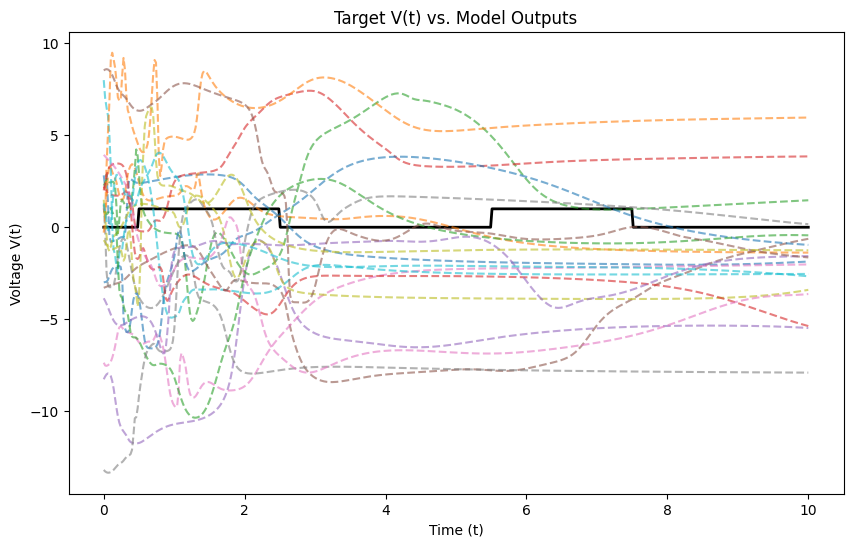

In [141]:
plt.figure(figsize=(10, 6))
target_values = [user_defined_function(t) if isinstance(user_defined_function(t), float) else user_defined_function(t).item() for t in t_vals]
plt.plot(t_vals, target_values, label='Target V(t)', linewidth=2, color='black')
for i, outputs in enumerate(model_outputs):
    plt.plot(t_vals, outputs, label=f'Model {i+1}', linestyle='dashed', alpha=0.6)
plt.xlabel('Time (t)')
plt.ylabel('Voltage V(t)')
plt.title('Target V(t) vs. Model Outputs')
plt.show()

This part of the code we start using Genetic Algorithem and pass it a number of generstions

In [148]:
n_gen = 21 # Number of generations 

In [152]:
def mutate(network, mutation_strength=0.2):
    """ Mutates the network by adding Gaussian noise to its weights and biases. """
    with torch.no_grad():
        for name, param in network.named_parameters():
            noise = torch.randn_like(param) * mutation_strength
            param.add_(noise)

In [153]:
def createGeneration(pop, t_vals):
    current_pop = pop
    selected_gens = [0, n_gen//3, n_gen//2, n_gen-1]
    best_losses_per_gen = []
    
    fig, axes = plt.subplots(1, len(selected_gens), figsize=(18, 4))
    
    for gen in range(n_gen):
        print("running Generation", gen)
        all_pop_outs = [compute_Q(nn.get_output, x0, t_vals[0], t_vals[-1]) for nn in current_pop]
        sorted_pops = np.argsort(all_pop_outs)
        best_losses_per_gen.append(min(all_pop_outs))
        
        
        if gen in selected_gens:
            ax = axes[selected_gens.index(gen)] if len(selected_gens) > 1 else axes
            ax.set_title(f"Generation {gen+1} - V(t) vs Time")
            ax.set_xlabel("Time")
            ax.set_ylabel("V(t)")
            
            for idx in sorted_pops[:3]:  # Plot 3 lowest Q values
                V_t = [current_pop[idx].get_output(t) for t in t_vals]
                ax.plot(t_vals, V_t, label=f"Model {idx+1}, Loss={all_pop_outs[idx]:.2f}")
            ax.legend()
        
        new_pop = [current_pop[idx] for idx in sorted_pops[:2]]
        while len(new_pop) < len(current_pop):
            parent_idx = np.random.choice(sorted_pops[:2])
            parent_network = current_pop[parent_idx]
            cloned_network = copy.deepcopy(parent_network)
            mutate(cloned_network)
            new_pop.append(cloned_network)
        
        current_pop = new_pop
    
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(n_gen), best_losses_per_gen, marker='o')
    plt.xlabel("Generation")
    plt.ylabel("Lowest Q Value")
    plt.title("Lowest Q Value per Generation")
    plt.show()

running Generation 0


/var/folders/29/b0gj9jmd6p7_zckwsxfjxty80000gs/T/ipykernel_11007/647666068.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Q, _ = quad(integrand, t_i, t_f)
/var/folders/29/b0gj9jmd6p7_zckwsxfjxty80000gs/T/ipykernel_11007/647666068.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Q, _ = quad(integrand, t_i, t_f)


running Generation 1
running Generation 2
running Generation 3
running Generation 4
running Generation 5
running Generation 6
running Generation 7
running Generation 8
running Generation 9
running Generation 10
running Generation 11
running Generation 12
running Generation 13
running Generation 14
running Generation 15
running Generation 16
running Generation 17
running Generation 18
running Generation 19
running Generation 20


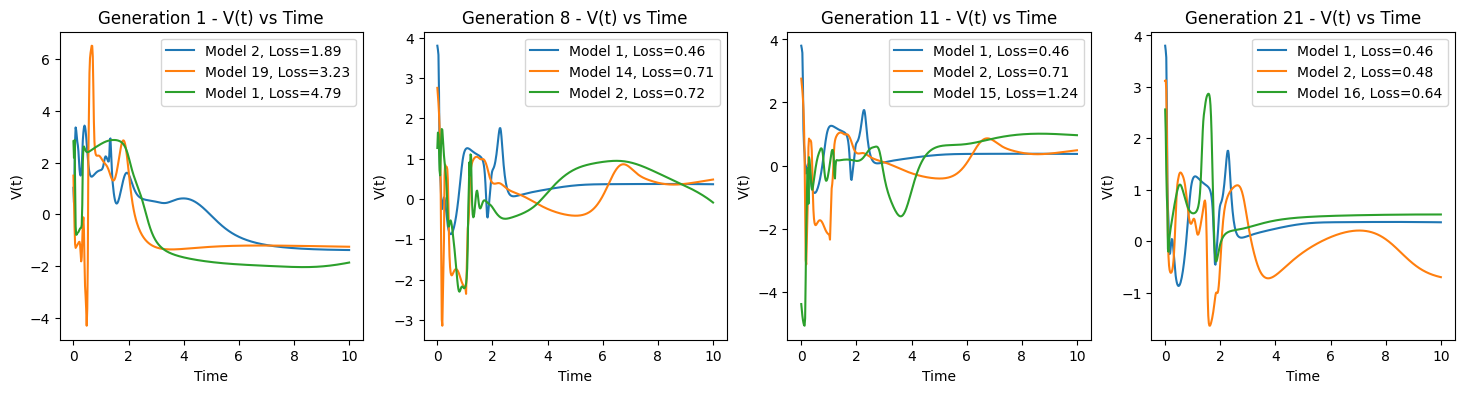

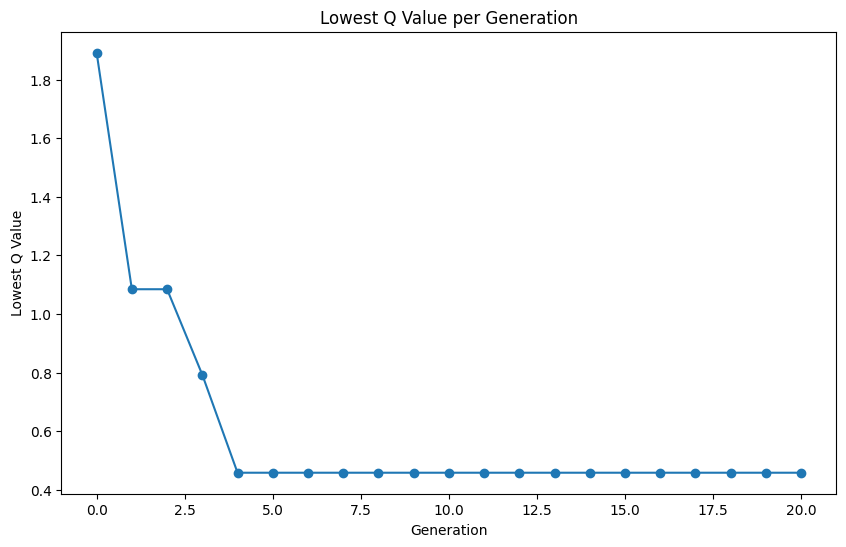

In [154]:
createGeneration(pop, t_vals)